# Steps to Follow

1. Install Dependencies
2. Load and pre-process the data
3. Data Augmentation
4. Detecting pose using detectron2
5. Classifying cricket shot using pose of a player
6. Evaluating model performance

###1. Install Dependencies

In [ ]:
!pip install python -m pip install pyyaml
# Detectron2 has not released pre-built binaries for the latest pytorch (https://github.com/facebookresearch/detectron2/issues/4053)
# so we install from source instead. This takes a few minutes.
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

# Install pre-built detectron2 that matches pytorch version, if released:
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
#!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/{CUDA_VERSION}/{TORCH_VERSION}/index.html

# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime pyyaml==5.1


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: -m
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-1npkxogl
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-1npkxogl
  Resolved https://github.com/facebookresearch/detectron2.git to commit d4a5f28e01b2babbaba9f90198fb95f5c661cccd
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 10

In [ ]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
torch:  2.0 ; cuda:  cu118
detectron2: 0.6



### 2. Load and pre-process the data

In [ ]:
# mount drive
from google.colab import drive
drive.mount('drive/')

Mounted at drive/


In [ ]:
# extract files
!unzip '/content/drive/MyDrive/shot-200715-184622.zip'

Archive:  /content/drive/MyDrive/shot-200715-184622.zip
   creating: shot/
   creating: shot/sweep/
  inflating: shot/sweep/_44955128_edwards_sweep1.jpg  
  inflating: shot/sweep/_41916434_staylor203.jpg  
  inflating: shot/sweep/_39319965_gibbs_gi300x245.jpg  
  inflating: shot/sweep/z_16-Roshen.jpg  
  inflating: shot/sweep/wp-1491721871824.jpg  
  inflating: shot/sweep/sp-13omjudd_v01.jpg.gallery.jpg  
  inflating: shot/sweep/shot9.jpg    
  inflating: shot/sweep/Rahul-Dravid-sweeps.jpg  
  inflating: shot/sweep/Mushfiqur-plays-a-sweep-shot.jpg  
  inflating: shot/sweep/james-foster-of-essex-plays-the-sweep-shot-as-ned-eckersley-looks-GRKN6E.jpg  
  inflating: shot/sweep/images99.jpg  
  inflating: shot/sweep/images90.jpg  
  inflating: shot/sweep/images80.jpg  
  inflating: shot/sweep/images8.jpg  
  inflating: shot/sweep/images76.jpg  
  inflating: shot/sweep/images75.jpg  
  inflating: shot/sweep/images215.jpg  
  inflating: shot/sweep/images213.jpg  
  inflating: shot/sweep/imag

In [ ]:
import os

# specify path
path='shot/'

# list down the folders 
folders = os.listdir(path)

print(folders)

['drive', 'cut', 'sweep', 'pull']


Unzipped folder contains 4 folders named 'drive', 'cut', 'sweep', 'pull' inside which respective images are stored

From all 4 folders images are stored in list 'images' and respective labels are stored in another list 'labels'.

In [ ]:
# for dealing with images
import cv2

# create lists
images  = []   # list to store images 
labels  = []   # list for storing shot names

# for each folder
for folder in folders:
    
    # list down image names
    names=os.listdir(path+folder)
    
    # for each image
    for name in names:
        
        # read an image
        img=cv2.imread(path+folder+'/'+name)
        
        # append image to list
        images.append(img)        

        # append folder name (type of shot) to list
        labels.append(folder)   

In [ ]:
#images[1]
labels[105]

'cut'

In [ ]:
# number of images
len(images)

290

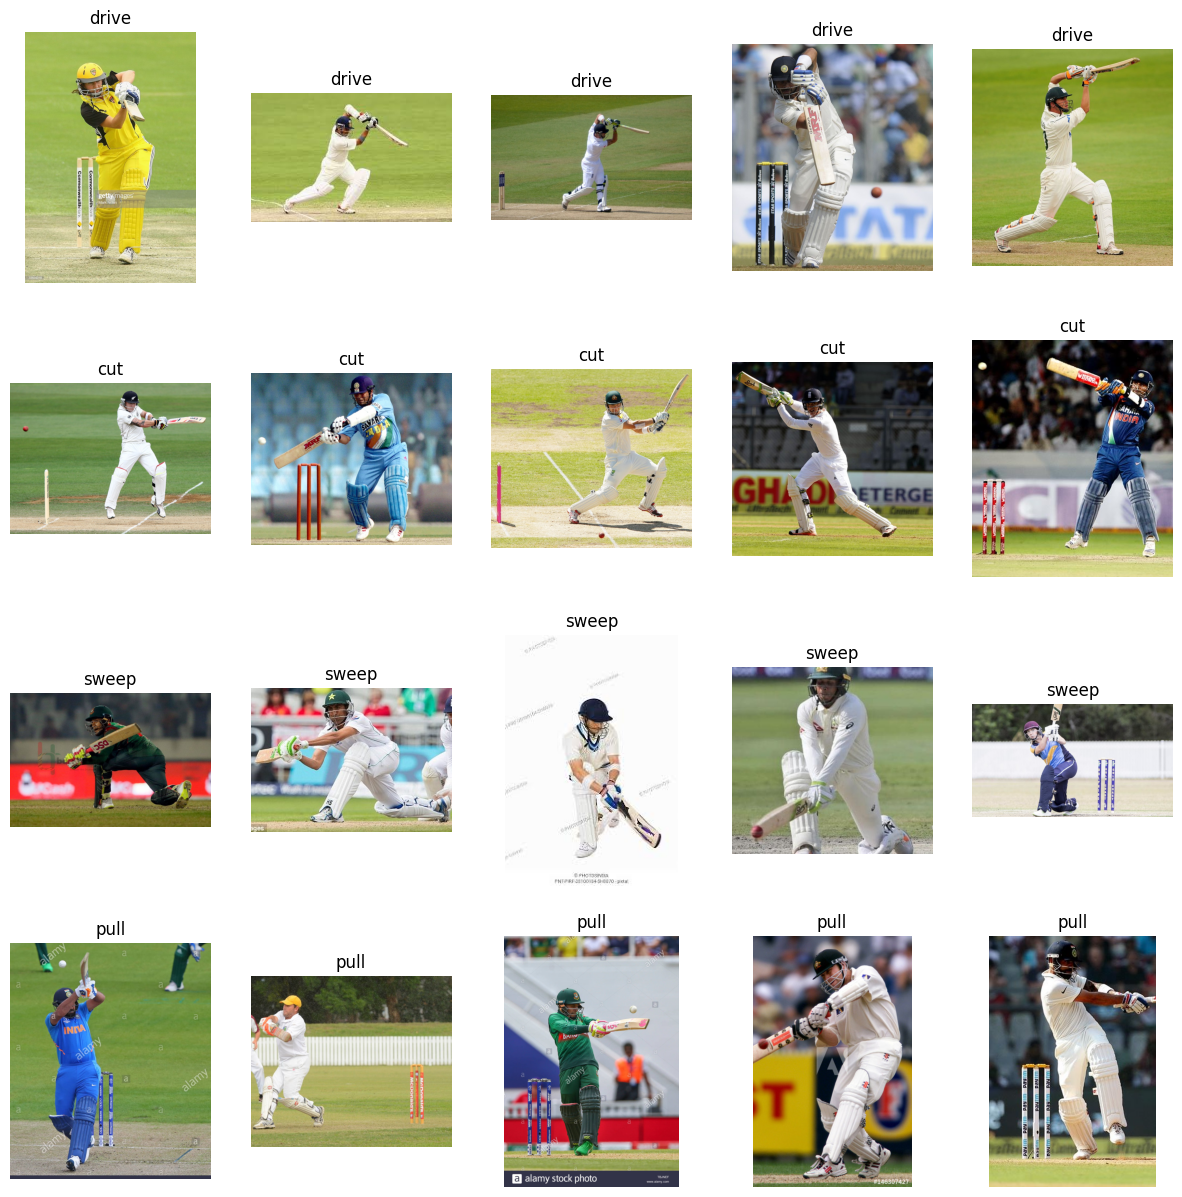

In [ ]:
# visualization library
import matplotlib.pyplot as plt

# for randomness
import random

# create subplots with 4 rows and 5 columns
fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(15,15))

# randomly display 5 images for each shot
# for each folder
for i in range(len(folders)):
    
    # read image names
    names=os.listdir(path+folders[i])
    
    # randomly select 5 image names
    names= random.sample(names, 5)

    # for each image
    for j in range(len(names)):

      # read an image 
      img = cv2.imread(path+ folders[i]+ '/' +names[j])

      # convert BGR to RGB
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

      # display image
      ax[i, j].imshow(img)

      # set folder name as title
      ax[i, j].set_title(folders[i])

      # Turn off axis
      ax[i, j].axis('off')

### 3. Data Augmentation

Each image is flipped to increase no of images. This way shot by right handed batsman will be same shot for left handed batsman without changing label.

In [ ]:
# image augmentation
aug_images=[]   # created list to append augmented images
aug_labels=[]    # created list to append augmented images respective labels

# for each image in training data
for idx in range(len(images)):   # select index from list of images created

  # fetch an image and label from respective lists
  img  = images[idx]
  label= labels[idx]           

  # flip an image
  img_flip = cv2.flip(img, 1)   # function to flip image

  # append augmented image to list
  aug_images.append(img_flip)

  # append label to list
  aug_labels.append(label) 

print('Now we have lists containing augmented images and respective labels') 

Now we have lists containing augmented images and respective labels


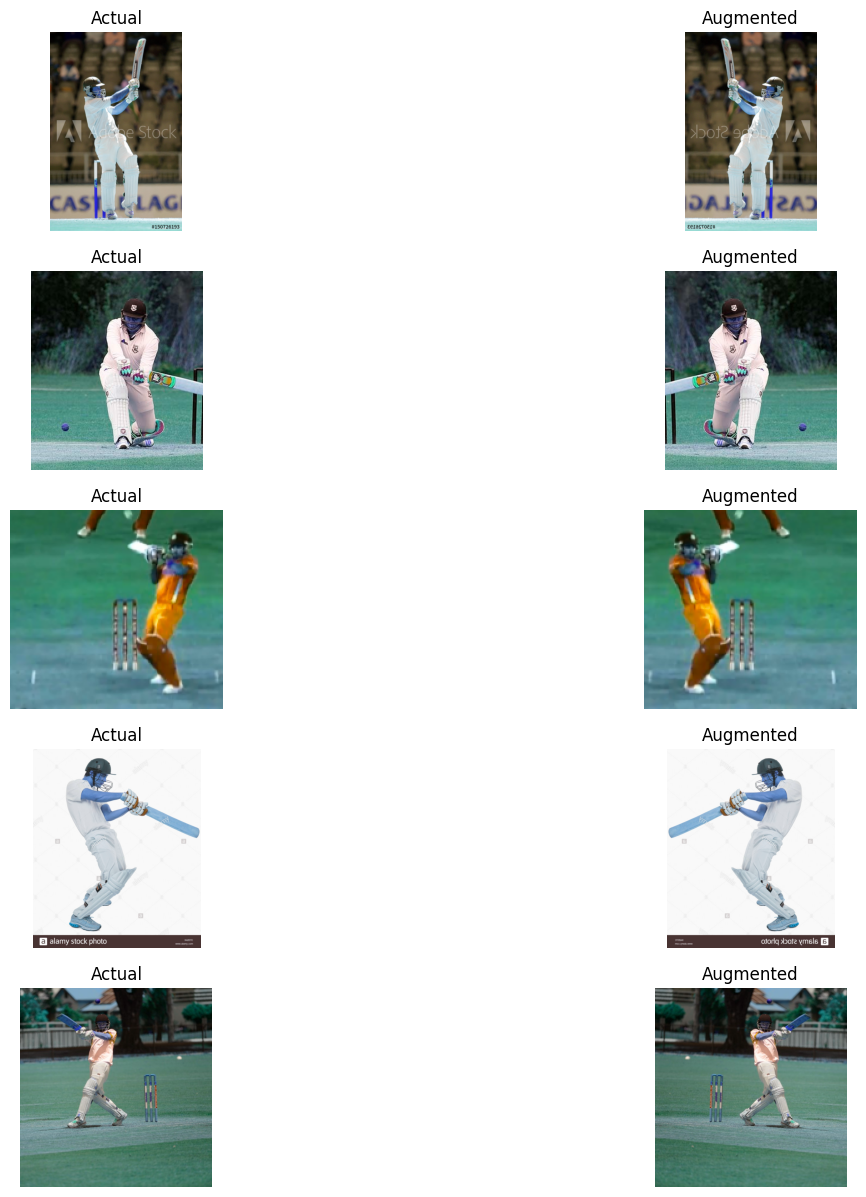

In [ ]:
# display actual and augmented image for sample images

# create indices
ind = range(len(aug_images))

# randomly sample indices
ind = random.sample(ind, 5)

# create subplots with 5 rows and 2 columns
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(15,15))

# for each row 
for row in range(5):
  
  # for each column
  for col in range(2):
    
    # first column for actual image
    if col==0:
      
      # display actual image
      ax[row, col].imshow(images[ ind[row] ] )

      # set title
      ax[row, col].set_title('Actual')

      # Turn off axis
      ax[row, col].axis('off')

    # second column for augmented image
    else:

      # display augmented image      
      ax[row, col].imshow(aug_images[ ind[row] ] )

      # set title
      ax[row, col].set_title('Augmented')

      # Turn off axis
      ax[row, col].axis('off')

In [ ]:
# combine actual and augmented images & labels
images = images + aug_images
labels = labels + aug_labels

In [ ]:
# number of images
len(images)

580

### 4. Detecting pose using detectron2

Here pretrained model is used for detecting bounding box and keypoints(pose) from detectron 2 library.

In [ ]:
# import some common detectron2 utilities
# to obtain pretrained models
from detectron2 import model_zoo

# set up predictor
from detectron2.engine import DefaultPredictor

# set config
from detectron2.config import get_cfg

# define configure instance
cfg = get_cfg()

# get a model specified by relative path under Detectron2’s official configs/ directory.
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_101_FPN_3x.yaml"))

# download pretrained model 
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_101_FPN_3x.yaml")

# set threshold for this model
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8  

# create predictor
predictor = DefaultPredictor(cfg)

model_final_997cc7.pkl: 313MB [00:05, 56.4MB/s]                          


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


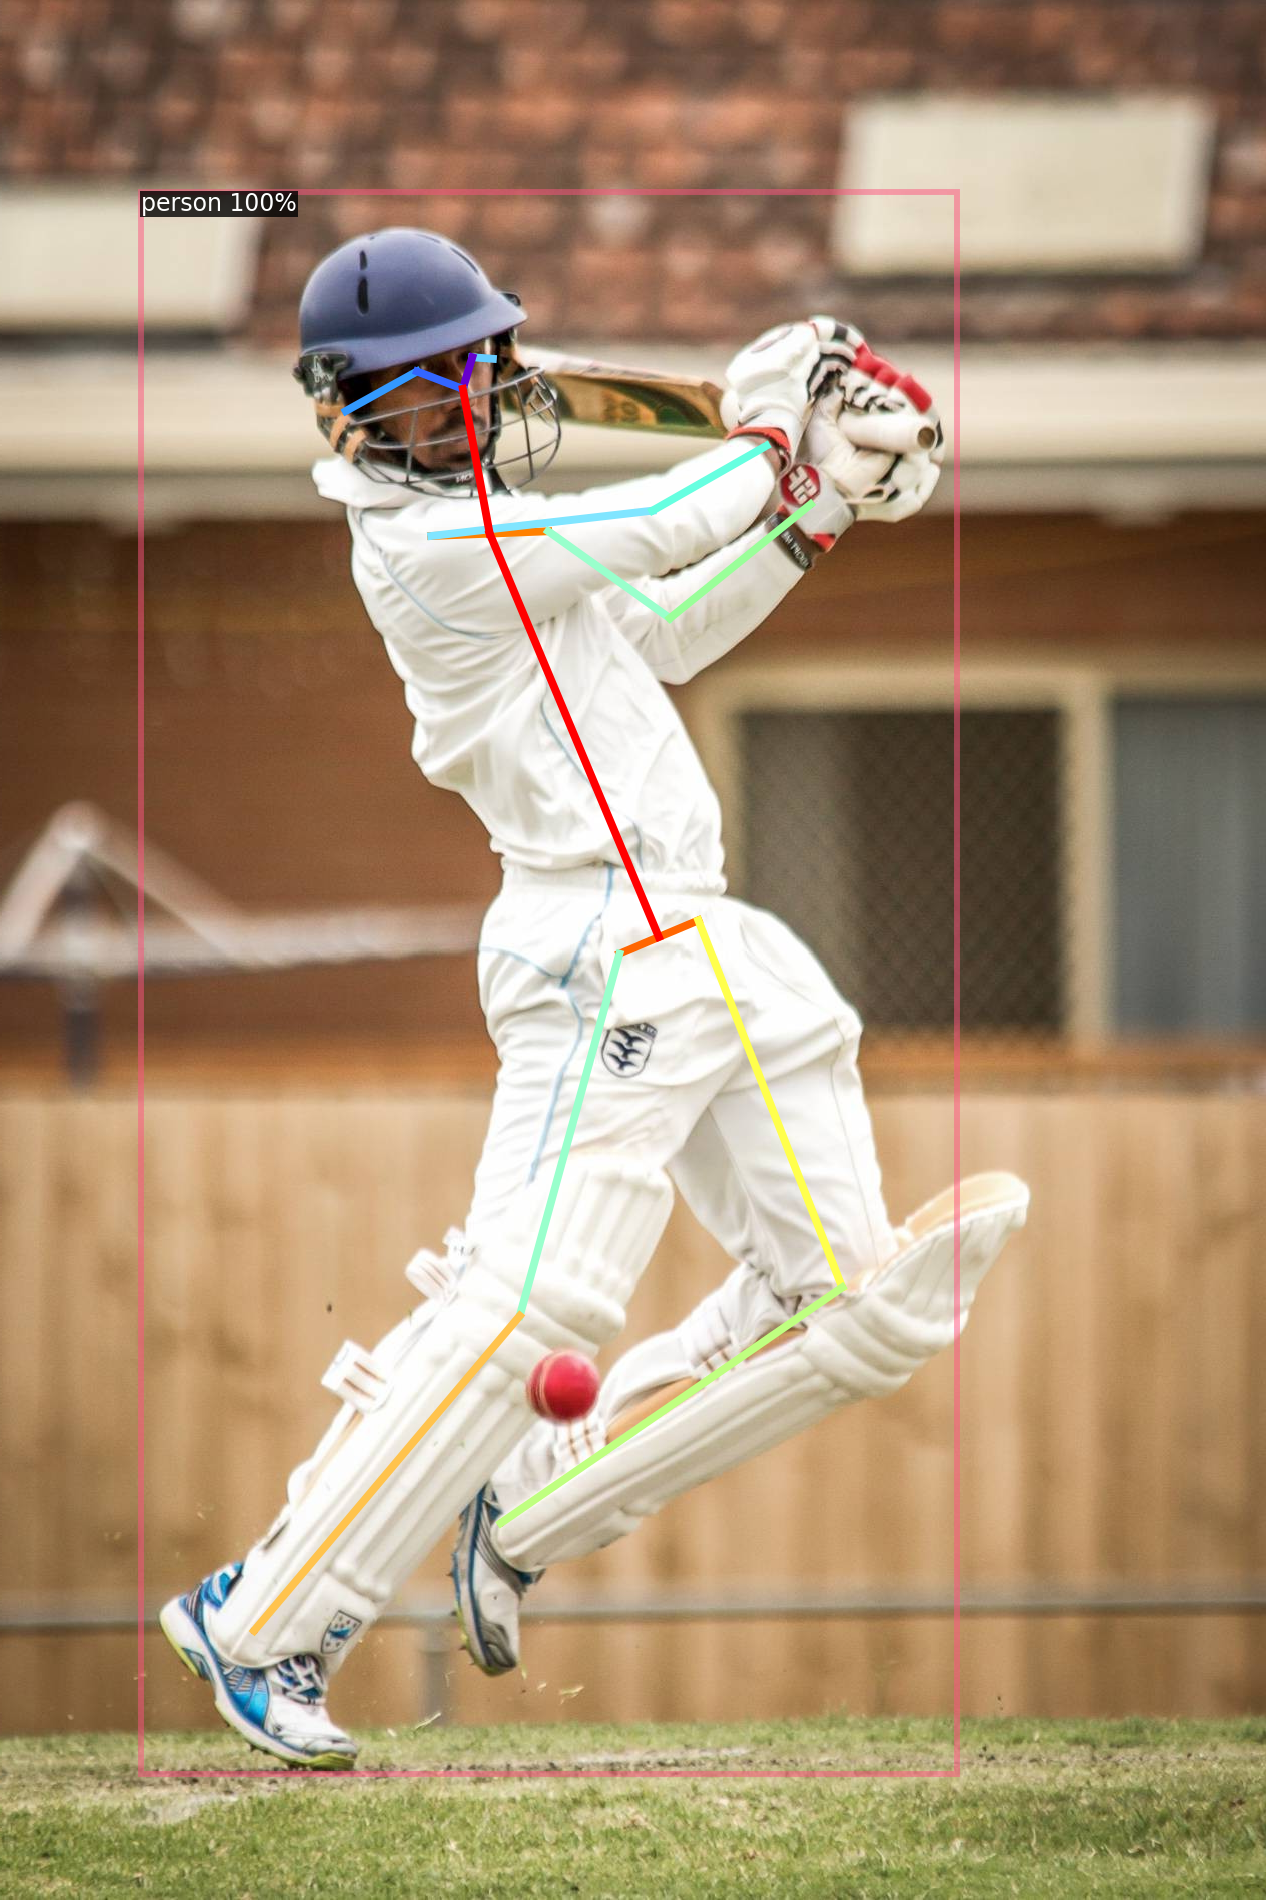

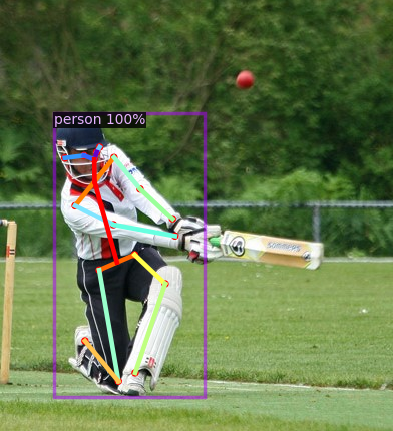

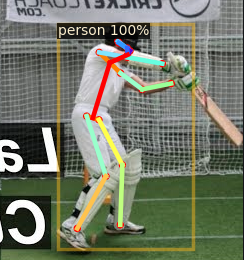

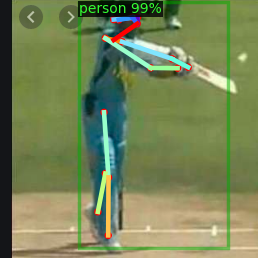

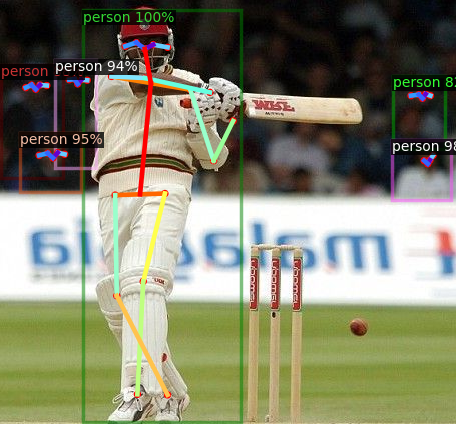

In [ ]:
# for drawing predictions on images
from detectron2.utils.visualizer import Visualizer

# to obtain metadata
from detectron2.data import MetadataCatalog

# to display an image
from google.colab.patches import cv2_imshow

# randomly select images
for img in random.sample(images,5):    
  
    # make predictions
    outputs = predictor(img)
    
    # use `Visualizer` to draw the predictions on the image.
    v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1)
    
    # draw prediction on image
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    
    # display image
    cv2_imshow(v.get_image()[:, :, ::-1])

From predicted positions, keypoints are stored in array. There is possiblity of multiple persons present in one image, the keypoints of highest probability bounding box are taken only. function for this is written below. 

In [ ]:
# define function that extracts the keypoints for an image
def extract_keypoints(img):  
  
  # make predictions
  outputs = predictor(img)
  
  # fetch keypoints
  keypoints = outputs['instances'].pred_keypoints
  
  # convert to numpy array
  kp = keypoints.cpu().numpy()
  
  # if keypoints detected
  if(len(keypoints)>0):
    
    # fetch keypoints of a person with maximum confidence score
    kp = kp[0]
    kp = np.delete(kp,2,1)
    
    # convert 2D array to 1D array
    kp = kp.flatten()
    
    # return keypoints
    return kp

In [ ]:
# progress bar
from tqdm import tqdm
import numpy as np

# create list
keypoints   = []

# for every image
for i in tqdm(range(len(images))):
  
  # extract keypoints
  kp = extract_keypoints(images[i])
  
  # append keypoints 
  keypoints.append(kp)

100%|██████████| 580/580 [01:37<00:00,  5.92it/s]


In [ ]:
keypoints[1]

array([ 378.75964,  314.56253,  400.9679 ,  292.3619 ,  359.01895,
        294.82864,  445.3844 ,  276.32816,  341.74588,  307.16232,
        518.1781 ,  345.39673,  338.0445 ,  421.86548,  530.51605,
        234.39368,  371.35687,  504.5011 ,  410.83823,  372.53076,
        386.16238,  504.5011 ,  590.97186,  657.43866,  478.69678,
        689.50616,  499.67126,  864.6442 ,  476.22922,  907.81213,
        510.7754 , 1174.2195 ,  562.5946 ,  997.8479 ], dtype=float32)

Each element in array is consist of 34 numbers, these will be 34 different input features for NN.

### 5. Classifying cricket shot using pose of a player



In [ ]:
# for normalization
from sklearn.preprocessing import StandardScaler

# define normalizer
scaler= StandardScaler()

# normalize keypoints
keypoints = scaler.fit_transform(keypoints)

# convert to an array
keypoints = np.array(keypoints)

In [ ]:
keypoints[1]   # Normalized

array([0.36600603, 1.83012204, 0.41773219, 1.78667063, 0.31921845,
       1.80661395, 0.53429079, 1.60261644, 0.29689708, 1.91785239,
       0.77361398, 1.52734433, 0.3520739 , 2.13246495, 0.91554741,
       0.34905992, 0.46554246, 2.34484791, 0.48380404, 1.35838401,
       0.43574035, 2.24055247, 1.11647585, 1.93671142, 0.9609224 ,
       2.09878396, 0.72312216, 1.86115933, 0.96336999, 2.03583826,
       0.77872626, 2.07837867, 1.21007929, 1.55566626])

In [ ]:
# converting the target categories (labels/text) into numbers
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y=le.fit_transform(labels)

In [ ]:
y

In [ ]:
# for creating training and validation sets
from sklearn.model_selection import train_test_split

# split keypoints and labels in 80:20
x_tr, x_val, y_tr, y_val = train_test_split(keypoints, y, test_size=0.2, stratify=labels, random_state=120)

In [ ]:
# converting the keypoints and target value to tensor
import torch
x_tr = torch.Tensor(x_tr)
x_val = torch.Tensor(x_val)
y_tr = torch.Tensor(y_tr)
y_tr = y_tr.type(torch.long)
y_val = torch.Tensor(y_val)
y_val = y_val.type(torch.long)

In [ ]:
x_val[1]

tensor([-0.5202, -0.4263, -0.5063, -0.4624, -0.5326, -0.4420, -0.4184, -0.5233,
        -0.5145, -0.3980, -0.2972, -0.6139, -0.4385, -0.1735, -0.3636, -0.2768,
        -0.4652,  0.0014, -0.5113,  0.1038, -0.5535,  0.4025, -0.1017, -0.3117,
        -0.2286, -0.2061, -0.2637, -0.4660, -0.2419,  0.0243, -0.5891, -0.2911,
         0.2105, -0.3986])

In [ ]:
y_val

tensor([0, 3, 1, 3, 3, 2, 0, 3, 1, 0, 2, 1, 3, 1, 1, 3, 2, 1, 1, 1, 2, 3, 0, 1,
        2, 3, 2, 1, 0, 3, 1, 2, 0, 3, 0, 1, 0, 1, 3, 1, 0, 3, 2, 1, 0, 3, 3, 1,
        3, 1, 2, 2, 0, 0, 2, 0, 2, 2, 3, 0, 1, 2, 3, 1, 2, 3, 1, 3, 0, 0, 2, 2,
        0, 2, 0, 2, 0, 1, 3, 3, 1, 0, 0, 1, 3, 2, 1, 2, 0, 1, 2, 1, 0, 3, 1, 0,
        0, 3, 3, 0, 2, 0, 3, 3, 2, 0, 3, 2, 2, 2, 1, 2, 2, 0, 3, 3])

In [ ]:
# shape of training and validation set
(x_tr.shape, y_tr.shape), (x_val.shape, y_val.shape)

((torch.Size([464, 34]), torch.Size([464])),
 (torch.Size([116, 34]), torch.Size([116])))

In [ ]:
# importing libraries for defining the architecture of model
from torch.autograd import Variable
from torch.optim import Adam
from torch.nn import Linear, ReLU, Sequential, Softmax, CrossEntropyLoss

In [ ]:
# defining the model architecture
model = Sequential(Linear(34, 64),
                   ReLU(),
                   
                   Linear(64, 4),
                   Softmax()
                   )

In [ ]:
# define optimizer and loss function
optimizer = Adam(model.parameters(), lr=0.01)
criterion = CrossEntropyLoss()

# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

In [ ]:
# Function to train model
def train(epoch):

    model.train()
    tr_loss = 0

    # getting the training set
    x_train, y_train = Variable(x_tr), Variable(y_tr)
    # getting the validation set
    x_valid, y_valid = Variable(x_val), Variable(y_val)

    # converting the data into GPU format
    if torch.cuda.is_available():
        x_train = x_train.cuda()
        y_train = y_train.cuda()
        x_valid = x_valid.cuda()
        y_valid = y_valid.cuda()

    # clearing the Gradients of the model parameters
    optimizer.zero_grad()
    
    # prediction for training and validation set
    output_train = model(x_train)
    output_val = model(x_valid)

    # computing the training and validation loss
    loss_train = criterion(output_train, y_train)
    loss_val = criterion(output_val, y_valid)

    # computing the updated weights of all the model parameters
    loss_train.backward()
    optimizer.step()
    if epoch%10 == 0:
        # printing the validation loss
        print('Epoch : ',epoch+1, '\t', 'loss :', loss_val.item())

In [ ]:
# defining the number of epochs
n_epochs = 100

# training the model
for epoch in range(n_epochs):
    train(epoch)

Epoch :  1 	 loss : 1.0073603391647339
Epoch :  11 	 loss : 1.0124913454055786
Epoch :  21 	 loss : 1.0057077407836914
Epoch :  31 	 loss : 1.0028088092803955
Epoch :  41 	 loss : 1.0008187294006348
Epoch :  51 	 loss : 1.0002723932266235
Epoch :  61 	 loss : 1.0119905471801758
Epoch :  71 	 loss : 1.0110961198806763
Epoch :  81 	 loss : 0.9925209283828735
Epoch :  91 	 loss : 1.0005848407745361


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


### 6. Evaluating model performance

In [ ]:
# to check the model performance
from sklearn.metrics import accuracy_score

In [ ]:
# get validation accuracy
x, y = Variable(x_val), Variable(y_val)
if torch.cuda.is_available():
  x_val = x.cuda()
  y_val = y.cuda()
pred = model(x_val)
final_pred = np.argmax(pred.cpu().data.numpy(), axis=1)
accuracy_score(y_val.cpu(), final_pred)

0.75